In [2]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.draw import polygon
import numpy as np
import pandas as pd
import os
import plistlib
import random
from subprocess import Popen
import math
PATH = "/mnt/d/Datasets/INbreast/"
ROI_PATH = PATH + "INbreast/INbreast_release_1.0/AllXML/"
IMG_PATH = PATH + "All-IMGS/"
save = PATH + 'full/'

img_width = 300
img_height = 600
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))

2023-02-15 15:19:33.811896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:19:34.331372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-15 15:19:34.331440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [3]:
# for dirName, subdirList, fileList in os.walk(IMG_PATH):
    # for fname in fileList:
        # if fname.endswith('.dcm'):
            # dcm_path = dirName+'/'+fname
            # img_path = dirName+'/'+fname.replace('.dcm','.png')
            # Popen(['convert',dcm_path,img_path]).wait()

In [4]:
inbreast = pd.read_csv(PATH + "INbreast.csv", encoding="ISO-8859-1" )
file_id = inbreast['File Name'].to_numpy()
birads = inbreast['Bi-Rads'].to_numpy()

In [5]:
#only have 3 cases, lets use it all in training for simplification
distortion_case = inbreast.loc[inbreast['Distortion']=='X']
# print(distortion_case)
asymmetry_case = inbreast.loc[inbreast['Asymmetry']=='X']
# print(np.vstack((asymmetry_case[:],asymmetry_case[-1])))
benign_asymmetry = asymmetry_case[(asymmetry_case['Bi-Rads'] == '2')|(asymmetry_case['Bi-Rads'] == '3')]
malignant_asymmetry = asymmetry_case[(asymmetry_case['Bi-Rads'] != '2')&(asymmetry_case['Bi-Rads'] != '3')&(asymmetry_case['Bi-Rads'] != '1')]
# asymmetry_train = np.concatenate((benign_asymmetry['File Name'].to_numpy()[:2],malignant_asymmetry['File Name'].to_numpy()[:4]))
# asymmetry_val = np.concatenate((benign_asymmetry['File Name'].to_numpy()[2:4],malignant_asymmetry['File Name'].to_numpy()[4:6]))
# asymmetry_test = np.concatenate((benign_asymmetry['File Name'].to_numpy()[4:],malignant_asymmetry['File Name'].to_numpy()[6:]))
distortion_train = distortion_case['File Name']
asymmetry_case = asymmetry_case['File Name']

In [6]:
mass_case =  inbreast.loc[inbreast['Mass ']=='X']
mass_case = mass_case.loc[mass_case['Distortion']!='X']
mass_case = mass_case.loc[mass_case['Asymmetry']!='X']
#only 24 benign masses
benign_mass = mass_case.loc[(mass_case['Bi-Rads'] == '2')|(mass_case['Bi-Rads'] == '3')]
malignant_mass = mass_case.loc[(mass_case['Bi-Rads'] != '2')&(mass_case['Bi-Rads'] != '3')&(mass_case['Bi-Rads'] != '1')]
#malignant mass has more
mass_case = mass_case['File Name'].to_numpy()
# mass_train = np.concatenate((benign_mass['File Name'].to_numpy()[:int(0.64*len(benign_mass)+1)]
                            # ,malignant_mass['File Name'].to_numpy()[:int(0.64*len(malignant_mass)+1)]))
# mass_val = np.concatenate((benign_mass['File Name'].to_numpy()[int(0.64*len(benign_mass)+1):int(0.8*len(benign_mass))]
                            # ,malignant_mass['File Name'].to_numpy()[int(0.64*len(malignant_mass)+1):int(0.8*len(malignant_mass))]))
# mass_test = np.concatenate((benign_mass['File Name'].to_numpy()[int(0.8*len(benign_mass)):]
                            # ,malignant_mass['File Name'].to_numpy()[int(0.8*len(malignant_mass)):]))

In [7]:
micro_case =  inbreast.loc[inbreast['Micros']=='X']
micro_case = micro_case.loc[micro_case['Distortion']!='X']
micro_case = micro_case.loc[micro_case['Asymmetry']!='X']
micro_case = micro_case.loc[micro_case['Mass ']!='X']
#only 24 benign masses
benign_micro = micro_case.loc[(micro_case['Bi-Rads'] == '2')|(micro_case['Bi-Rads'] == '3')]
malignant_micro = micro_case.loc[(micro_case['Bi-Rads'] != '2')&(micro_case['Bi-Rads'] != '3')&(micro_case['Bi-Rads'] != '1')]
#malignant mass has more
# micro_train = np.concatenate((benign_micro['File Name'].to_numpy()[:int(0.64*len(benign_micro)+1)]
                            # ,malignant_micro['File Name'].to_numpy()[:int(0.64*len(malignant_micro)+1)]))
# micro_val = np.concatenate((benign_micro['File Name'].to_numpy()[int(0.64*len(benign_micro)+1):int(0.8*len(benign_micro))]
                            # ,malignant_micro['File Name'].to_numpy()[int(0.64*len(malignant_micro)+1):int(0.8*len(malignant_micro))]))
# micro_test = np.concatenate((benign_micro['File Name'].to_numpy()[int(0.8*len(benign_micro)):]
                            # ,malignant_micro['File Name'].to_numpy()[int(0.8*len(malignant_micro)):]))
benign_micro

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,...,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
8,removed,removed,L,MLO,201001.0,50997434.0,3,2,NaN,X,...,micro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,removed,removed,L,CC,201001.0,50997488.0,3,2,NaN,X,...,micro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,removed,removed,R,CC,201001.0,50998032.0,3,2,NaN,X,...,micros + calcificação vasos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,removed,removed,R,MLO,201001.0,50998086.0,3,2,NaN,X,...,micros + calcificação vasos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,removed,removed,L,MLO,201001.0,50997742.0,1,3,NaN,X,...,micros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,removed,removed,L,CC,201001.0,22613796.0,2,2,NaN,X,...,micros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,removed,removed,L,MLO,200802.0,24055725.0,4,2,NaN,X,...,micros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,removed,removed,R,MLO,200802.0,24055752.0,4,2,NaN,X,...,micros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,removed,removed,L,CC,200802.0,24055779.0,4,2,NaN,X,...,micros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# train_set = np.concatenate((distortion_train,asymmetry_train,micro_train,mass_train))
# val_set = np.concatenate((asymmetry_val,micro_val,mass_val))
# test_set = np.concatenate((asymmetry_test,micro_test,mass_test))
rng = np.random.default_rng(seed=42)
benign_asymmetry_rand = rng.permutation(benign_asymmetry['File Name'].to_numpy())
benign_mass_rand = rng.permutation(benign_mass['File Name'].to_numpy())
benign_micro_rand = rng.permutation(benign_micro['File Name'].to_numpy())
malignant_asymmetry_rand = rng.permutation(malignant_asymmetry['File Name'].to_numpy())
malignant_mass_rand = rng.permutation(malignant_mass['File Name'].to_numpy())
malignant_micro_rand = rng.permutation(malignant_micro['File Name'].to_numpy())
benign_train = np.concatenate((distortion_train.to_numpy()
                                , benign_asymmetry_rand[:2]
                                , benign_mass_rand[:int(0.64*len(benign_mass))]
                                , benign_micro_rand[:int(0.64*len(benign_micro))]
                                ))
benign_val = np.concatenate((benign_asymmetry_rand[2:4]
                                , benign_mass_rand[int(0.64*len(benign_mass)):int(0.8*len(benign_mass))]
                                , benign_micro_rand[int(0.64*len(benign_micro)):int(0.8*len(benign_micro))]
                                ))
benign_test = np.concatenate((benign_asymmetry_rand[4:]
                                , benign_mass_rand[int(0.8*len(benign_mass)):]
                                , benign_micro_rand[int(0.8*len(benign_micro)):]
                                ))
malignant_train = np.concatenate((malignant_asymmetry_rand[:2]
                                , malignant_mass_rand[:int(0.64*len(malignant_mass)-3)]
                                , malignant_micro_rand[:int(0.64*len(malignant_micro))]
                                ))
malignant_val = np.concatenate((malignant_asymmetry_rand[2:4]
                                , malignant_mass_rand[int(0.64*len(malignant_mass)-3):int(0.8*len(malignant_mass))]
                                , malignant_micro_rand[int(0.64*len(malignant_micro)):int(0.8*len(malignant_micro))]
                                ))
malignant_test = np.concatenate((malignant_asymmetry_rand[4:]
                                , malignant_mass_rand[int(0.8*len(malignant_mass)):]
                                , malignant_micro_rand[int(0.8*len(malignant_micro)):]
                                ))


In [9]:
len(malignant_micro_rand[:int(0.64*len(malignant_micro))])

12

In [10]:
print(len(malignant_train))

55


In [11]:
# file_name = '20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm'
# id = file_name.split('_')[0]
# row = inbreast.loc[inbreast['File Name']==id]
# print(row['Bi-Rads'].to_numpy())

In [12]:
# benign = inbreast.loc[inbreast['Bi-Rads']=='2']
# malignant = inbreast.loc[inbreast['Bi-Rads']!='2']
# malignant = malignant.loc[malignant['Bi-Rads']!='1']
# malignant = malignant[:-2]
# rng = np.random.default_rng(seed=42)
# malignant= rng.permutation(malignant['File Name'].to_numpy())
# benign= rng.permutation(benign['File Name'].to_numpy())
# benign = benign[:len(malignant)]
# test_set = int(0.2*len(benign))
# val_set = int(0.8*0.2*len(benign))
# train_set = len(benign) - test_set - val_set
# benign_train = benign[:train_set]
# benign_val = benign[train_set:-test_set]
# benign_test = benign[-test_set:]
# test_set = int(0.2*len(malignant))
# val_set = int(0.8*0.2*len(malignant))
# train_set = len(malignant) - test_set - val_set
# malignant_train = malignant[:train_set]
# malignant_val = malignant[train_set:-test_set]
# malignant_test = malignant[-test_set:]
# print(train_set)


In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  # tf.keras.layers.RandomRotation((0,0.5),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])

2023-02-15 15:19:35.903072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:19:35.905034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 15:19:35.905114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 15:19:35.905135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

# Full Image Processing



In [261]:
def preprocess(file_path):
    data = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    # data_blur = cv2.GaussianBlur(data, (5, 5), 5)
    # _, thresh = cv2.threshold(data_blur, 250, 255, cv2.THRESH_BINARY_INV)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # largest_contours = max(contours, key=cv2.contourArea)
    # img_contour = np.zeros(data.shape,np.uint8)
    # cv2.drawContours(img_contour, [largest_contours], -1, 255, -1)
    # img_no_bg = cv2.bitwise_and(data_blur,data_blur,mask=img_contour)
    # _, thresh = cv2.threshold(img_no_bg, 10, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # largest_contours = max(contours, key=cv2.contourArea)
    # img_contour = np.zeros(data.shape,np.uint8)
    # cv2.drawContours(img_contour, [largest_contours], -1, 255, -1)
    # img_no_label = cv2.bitwise_and(img_no_bg,img_no_bg,mask=img_contour) 
    # data = clahe.apply(data)
    img=cv2.resize(data,(img_width,img_height))
    return img

def process_image(file_path,data_set,category,file_save,augment=False):
    # image_dir = tf.compat.as_str(file_path.numpy())
    image_dir = file_path
    image = preprocess(image_dir)
    image_name = image_dir.split('/')[-1].split('.')[0]
    save_path = str(save) + str(data_set) +'/'+str(category)+'/'+str(file_save)
    print(save_path) 
    directory = str(save) + str(data_set) +'/'+str(category)
    if not os.path.exists(directory):
        os.makedirs(directory)
    cv2.imwrite(save_path+'_1.png',image)
    img = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    if augment:
        for i in range(augment):
            img2 = data_augmentation(img)    
            cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())

In [133]:
for dirName, subdirList, fileList in os.walk(IMG_PATH):
    for file in fileList:
        if file.endswith('.png'):
            file_name = float(file.split('_')[0])
            if file_name in benign_val:
                process_image(dirName+'/'+file,'val','benign',int(file_name))
            elif file_name in benign_test:
                process_image(dirName+'/'+file,'test','benign',int(file_name))
            elif file_name in benign_train:
                process_image(dirName+'/'+file,'train','benign',int(file_name),augment=False)
            elif file_name in malignant_val:
                process_image(dirName+'/'+file,'val','malignant',int(file_name),augment=1)
            elif file_name in malignant_test:
                process_image(dirName+'/'+file,'test','malignant',int(file_name))
            elif file_name in malignant_train:
                process_image(dirName+'/'+file,'train','malignant',int(file_name),augment=2)
            else:
                print(str(file_name)+' not selected')

NameError: name 'process_image' is not defined

In [263]:
# benign = []
# asymmetry = inbreast.loc[inbreast['Asymmetry']=='X']
# asymmetry_benign = asymmetry.loc[asymmetry['Bi-Rads']=='2']
# print(asymmetry_benign)
# asymmetry_malignant = asymmetry.loc[asymmetry['Bi-Rads']!='2']
# print(asymmetry_malignant)
# 

In [264]:
# micros = inbreast.loc[inbreast['Micros']=='X']
# micros_benign = micros.loc[micros['Bi-Rads']=='2'].to_numpy()
# print(micros_benign)
# micros_malignant = micros.loc[micros['Bi-Rads']!='2'].to_numpy()
# print(micros_malignant)


# ROI Extraction

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.5),fill_mode='reflect'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='reflect')
  ])

In [15]:
def load_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [eval(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[1]), int(point[0])] = 255
            else:
                x, y = zip(*points)
                col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
                poly_x, poly_y = polygon(row, col, shape=imshape)
                mask[poly_x, poly_y] = 255
    return mask

#Reference from https://gist.github.com/Feyn-Man/de6f62997d051fc6ff75a6aa968537f5, Accessed on 12/1/2023


In [16]:
Preprocessing = ''
roi_save = PATH + 'ROI/' + Preprocessing
img_height = 300
img_width = 300

In [18]:
# def ROI():
    # mask = load_mask(ROI_PATH + "50998634.xml")
    # Full_image = cv2.imread(IMG_PATH+'50998634_cd12bc20b3d27d0b_MG_L_CC_ANON.png')
    # mask = mask.astype(np.uint8)
    # mask = cv2.merge([mask])
    # _,thresh = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # largest_contours = max(contours, key=cv2.contourArea)
    # x,y,w,h = cv2.boundingRect(largest_contours)
    # img = cv2.rectangle(Full_image,(x,y),(x+w,y+h),(255,255,255),10)

def ROI(file_path,data_set,category,file_name,augment=False):
    # image_dir = tf.compat.as_str(file_path.numpy())
    # image_dir = file_path
    data = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    
    mask = load_mask(ROI_PATH + str(file_name)+'.xml',imshape=data.shape)
    mask = mask.astype(np.uint8)
    mask = cv2.merge([mask])
    _,thresh = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    y -=50
    x -=50
    h +=100
    w +=100
    # if h < 300:
        # h = 300
    # if w < 300:
        # w = 300
    if y<0:
        y=0
    if y+h>data.shape[0]:
        y = data.shape[0] - h
    if x<0:
        x=0
    if x+w>data.shape[1]:
        x = data.shape[1] - w
    data = data[y:y+h,x:x+w]
    # data = clahe.apply(data)
    image=cv2.resize(data,(img_width,img_height))
    # image_name = file_path.split('/')[-1].split('.')[0]
    
    save_path = str(roi_save) + str(data_set) +'/'+str(category)+'/'+str(file_name)
    print(save_path) 
    directory = str(roi_save) + str(data_set) +'/'+str(category)
    if not os.path.exists(directory):
        os.makedirs(directory)
    cv2.imwrite(save_path+'_1.png',image)
    img = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    if augment:
        for i in range(augment):
            img2 = data_augmentation(img)    
            cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())



In [19]:
for dirName, subdirList, fileList in os.walk(IMG_PATH):
    for file in fileList:
        if file.endswith('.png'):
            file_name = float(file.split('_')[0])
            if file_name in benign_val:
                ROI(dirName+'/'+file,'val','benign',int(file_name))
            elif file_name in benign_test:
                ROI(dirName+'/'+file,'test','benign',int(file_name))
            elif file_name in benign_train:
                ROI(dirName+'/'+file,'train','benign',int(file_name),augment=False)
            elif file_name in malignant_val:
                ROI(dirName+'/'+file,'val','malignant',int(file_name),augment=1)
            elif file_name in malignant_test:
                ROI(dirName+'/'+file,'test','malignant',int(file_name))
            elif file_name in malignant_train:
                ROI(dirName+'/'+file,'train','malignant',int(file_name),augment=2)
            else:
                print(str(file_name)+' not selected')

/mnt/d/Datasets/INbreast/ROI/train/benign/20586908
/mnt/d/Datasets/INbreast/ROI/train/malignant/20586934
/mnt/d/Datasets/INbreast/ROI/train/benign/20586960
/mnt/d/Datasets/INbreast/ROI/train/malignant/20586986
/mnt/d/Datasets/INbreast/ROI/val/malignant/20587054
/mnt/d/Datasets/INbreast/ROI/train/malignant/20587080
/mnt/d/Datasets/INbreast/ROI/train/benign/20587148
/mnt/d/Datasets/INbreast/ROI/train/benign/20587174
/mnt/d/Datasets/INbreast/ROI/train/benign/20587200
/mnt/d/Datasets/INbreast/ROI/train/benign/20587226
/mnt/d/Datasets/INbreast/ROI/train/benign/20587294
/mnt/d/Datasets/INbreast/ROI/test/benign/20587320
/mnt/d/Datasets/INbreast/ROI/train/benign/20587346
/mnt/d/Datasets/INbreast/ROI/train/benign/20587372
/mnt/d/Datasets/INbreast/ROI/train/benign/20587466
/mnt/d/Datasets/INbreast/ROI/test/benign/20587492
/mnt/d/Datasets/INbreast/ROI/train/benign/20587518
/mnt/d/Datasets/INbreast/ROI/train/benign/20587544
/mnt/d/Datasets/INbreast/ROI/train/malignant/20587612
/mnt/d/Datasets/INbr

0.0
0.0
0.0
0.0
0.0022295000962913036
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.007533750031143427
0.0
0.0012740000383928418
0.0
0.0
0.42805787920951843
0.0
0.0
0.0
0.0
0.0
0.0
0.0038219999987632036
0.0
0.0
0.0025173749309033155
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0009309999877586961
1.3665732145309448
0.0
0.012935999780893326
0.0013230000622570515
0.000784000032581389
0.0


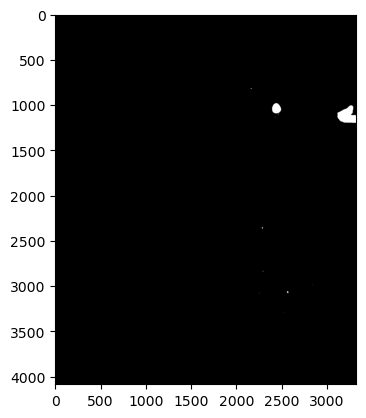

In [59]:

# To load largest ROI in XML file
mask = np.zeros((4084,3328))
with open(ROI_PATH + "20586908.xml", 'rb') as mask_file:
    plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
    numRois = plist_dict['NumberOfROIs']
    rois = plist_dict['ROIs']
    assert len(rois) == numRois
    prevPoints = 0
    for roi in rois:
        area = roi['Area']
        print(area)
        numPoints = roi['NumberOfPoints']
        points = roi['Point_px']
        assert numPoints == len(points)
        points = [eval(point) for point in points]
        if len(points) <= 2:
            for point in points:
                mask[int(point[1]), int(point[0])] = 0
        else:
            x, y = zip(*points)
            col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
            poly_x, poly_y = polygon(row, col, shape=mask.shape)
            mask[poly_x, poly_y] = 255
        # if numPoints > prevPoints:
            # point = points
            # prevPoints = numPoints
    # for x in point:
        # mask[int(x[1])-5:int(x[1])+5, int(x[0])-5:int(x[0])+5] = 1

plt.imshow(mask, cmap='gray')

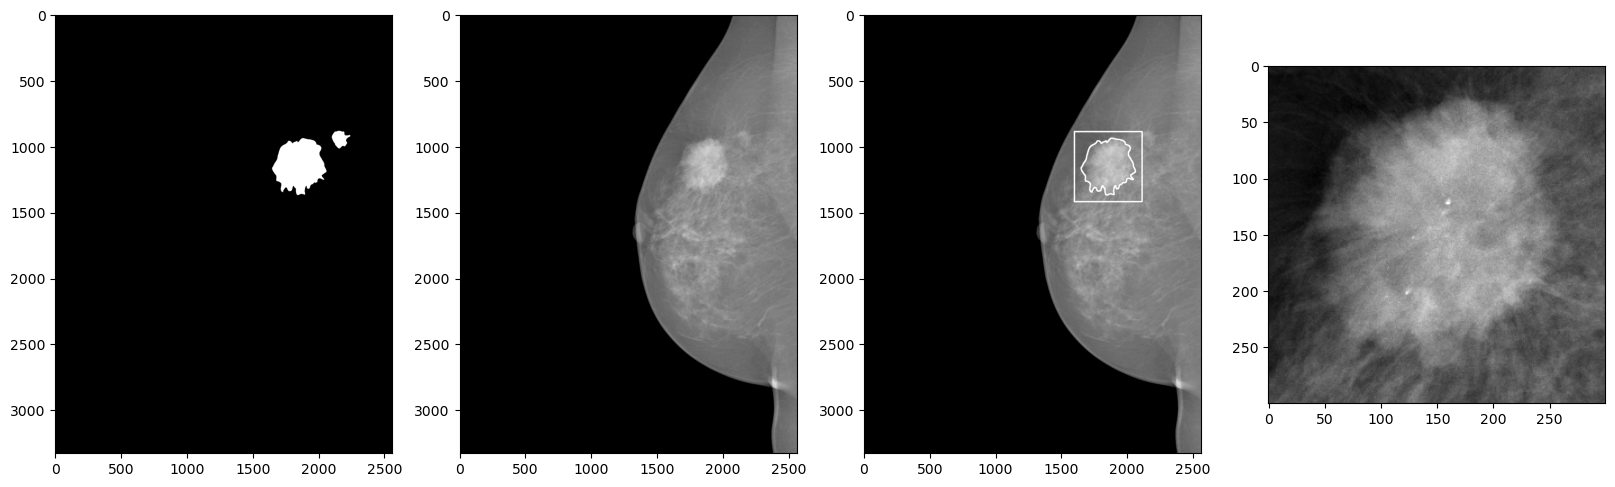

In [29]:
plt.figure(figsize=(20,60))

# Test_box = cv2.cvtColor(Test_box, cv2.COLOR_RGB2GRAY)
Full_image = cv2.imread(IMG_PATH+'22579730_bbd6a3a35438c11b_MG_R_ML_ANON.png',cv2.IMREAD_GRAYSCALE)
image = cv2.imread(IMG_PATH+'22579730_bbd6a3a35438c11b_MG_R_ML_ANON.png',cv2.IMREAD_GRAYSCALE)
# print(Full_image.shape)
Test_box = load_mask(ROI_PATH + "22579730.xml",imshape=Full_image.shape)
# print(Test_box[:,:,0])
Test_box = Test_box.astype(np.uint8)
Test_box = cv2.merge([Test_box])
plt.subplot(141)
plt.imshow(Test_box,cmap='gray')
plt.subplot(142)
plt.imshow(Full_image, cmap='gray')
_,thresh = cv2.threshold(Test_box,0,255,cv2.THRESH_BINARY)
img = Full_image
# edges = cv2.Canny(Test_box,100,200)
contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
largest_contours = max(contours, key=cv2.contourArea)

x,y,w,h = cv2.boundingRect(largest_contours)
# print(Full_image.shape)
y -=50
x -=50
h +=100
w +=100
# if h < 300:
    # h = 300
# if w < 300:
    # w = 300
if y<0:
    y=0
if y+h>Test_box.shape[0]:
    y = Test_box.shape[0] - h
if x<0:
    x=0
if x+w>Test_box.shape[1]:
    x = Test_box.shape[1] - w

roi = image[y:y+h,x:x+w]
with_contour = cv2.drawContours(img,[largest_contours],0,255,10)
img = cv2.rectangle(Full_image,(x,y),(x+w,y+h),255,10)



# for cont in contours:
    # print(cv2.contourArea(cont))
    # if cv2.contourArea(cont) > 1000:
        # x,y,w,h = cv2.boundingRect(cont)
        # img = cv2.rectangle(Full_image,(x,y),(x+w,y+h),(255,255,255),10)
plt.subplot(143)
plt.imshow(with_contour, cmap='gray')
# newimg = img[img.shape[0]-(y+h):img.shape[0]-y,]
roi=cv2.resize(roi,(img_width,img_height))
plt.subplot(144)
plt.imshow(roi, cmap='gray')